# Setting the plasmon parameters

For the QUOTAS model, we have introduced two parameters used in the calculation of plasmon excitations. As we want to make predictions for the secondary emission yield of other materials, we want to fix these parameters for the model before applying it to the metals for which we have calculated the required input. As we only have experimental results for Mg, Al, Be, Cu(110), Ni(111) and W, we will fit the parameters to these yield distributions.

We'll begin by importing the required packages/objects, as well as the experimental data.

In [2]:
# Notebook header <--- Always run this cell first!
import os, json
import numpy as np
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
%matplotlib inline

from ipywidgets import interact, FloatSlider, FloatText
from monty.json import MontyDecoder, MontyEncoder
from pymatgen.io.vasp.outputs import Outcar, Vasprun

from quotas.core import QuotasCalculator, WorkFunctionData, DielTensor

data_dir = "../data/"

# Load the experimental data
with open(os.path.join(data_dir, "experimental_data.json"), "r") as file:
    exp_data = json.loads(file.read(), cls=MontyDecoder)
    
# Load the dictionary of all the structures for which we have calculated the required properties
with open("../structure_dict.yaml", "r") as file:
    structure_dict = yaml.safe_load(file.read())
    
def get_smeared_densities(energies, densities, sigma):
    """
    Use a Gaussian kernel to smear a density distribution.

    Args:
        sigma: Std dev of Gaussian smearing function.

    Returns:
        Gaussian-smeared densities.
    """
    from scipy.ndimage.filters import gaussian_filter1d
    
    diff = np.diff(energies)
    avgdiff = sum(diff) / len(diff)
    
    smeared_dens = gaussian_filter1d(densities, sigma / avgdiff)
    return smeared_dens

The data for the surfaces are stored as `QuotasCalculator` json files in the `data` directory. Here's an example of how to load one and calculate the yield spectrum:

In [3]:
quotas = QuotasCalculator.from_file(os.path.join(data_dir, "Al_100_pbe.json"))
see = quotas.calculate_yield(22.58)

(0, 20)

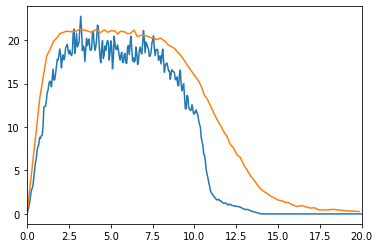

In [4]:
plt.plot(see["energy"], see["yield"]*1e3)
plt.plot(exp_data["Al"]["He"]["energy"], exp_data["Al"]["He"]["yield"])
plt.xlim([0, 20])

## Influence of the plasmon parameters

We'll first check the influence of the plasmon parameters using an interactive tool. The cell below sets up a dictionary that contains all of the `QuotasCalculator` objects for the various surfaces. This takes a little while to load.

In [5]:
quotas_dict = {
    "Al": {"100": None, "110": None, "111": None},
    "Mg": {"100": None, "110": None, "001": None},
    "Be": {"100": None, "110": None, "001": None},
    "Ni": {"100": None, "110": None, "111": None},
    "W": {"100": None, "110": None, "111": None},
    "Cu": {"100": None, "110": None, "111": None}
}

for element in quotas_dict.keys():
    for surface in quotas_dict[element].keys():
        quotas_dict[element][surface] = QuotasCalculator.from_file(
            os.path.join(data_dir, element + "_" + surface + "_pbe.json")
        )

Let's also set up a little dictionary with the ionization energies. Note the substractions from the free atom ionization energies, these represent the correction due to the image charge.

In [6]:
ionization_energies = {
    "He": 24.59 - 2,
    "Ne": 21.56 - 1,
    "Ar": 15.76 - 0.5,
    "Kr": 14.00,
    "Xe": 12.13
}

The function below allows us to test a range of parameters for a choice of surface and incident ion, using the `interact` method of `ipywidgets`.

In [7]:
def test_plasmon_parameters(element, surface, ion, bulk_parameter, surface_parameter):
    
    if surface == "average":
        see_results = []
        for surf in quotas_dict[element].keys():
            quotas = quotas_dict[element][surf]
            quotas.set_up_plasmon_probabilities(bulk_parameter, surface_parameter)
            see_results.append(quotas.calculate_yield(ionization_energies[ion]))
        energy = exp_data[element][ion]["energy"]
        see_yield = np.zeros(energy.shape)
        for see in see_results:
            see_yield += np.interp(energy, see["energy"], see["yield"])/len(see_results)
        plt.plot(energy, see_yield * 1e3)
        plt.plot(exp_data[element][ion]["energy"], exp_data[element][ion]["yield"])
        plt.xlabel("Electron Energy (eV)")
        plt.ylabel("10^3 yield/ion")
        print("Total Yield = " + str(np.trapz(see_yield, energy)))
        print("Experimental Yield = " + str(np.trapz(exp_data[element][ion]["yield"]/1e3, energy)))
        
    else:
        try:
            quotas = quotas_dict[element][surface]
        except KeyError:
            print("The chosen element/surface combination is not available.")
        else:
            print("Surface work function = " + str(round(quotas.workfunction_data.work_function, 2)))
            quotas.set_up_plasmon_probabilities(bulk_parameter, surface_parameter)
            see = quotas.calculate_yield(ionization_energies[ion])
            plt.plot(see["energy"], see["yield"] * 1e3)
            plt.plot(exp_data[element][ion]["energy"], exp_data[element][ion]["yield"])
            plt.xlabel("Electron Energy (eV)")
            plt.ylabel("10^3 yield/ion")
            print("Total yield = " + str(see["total_yield"]))
            print("Experimental Yield = " + str(np.trapz(exp_data[element][ion]["yield"] / 1e3, exp_data[element][ion]["energy"])))

Running the cell below will boot the interactive interface for testing out the plasmon parameters.

In [8]:
interact(test_plasmon_parameters,
         element=quotas_dict.keys(), 
         surface=["100", "110", "001", "111", "average"], 
         ion=ionization_energies.keys(), 
         bulk_parameter=FloatSlider(0.11, min=0, max=0.2, step=0.005, readout_format=".3f"), 
         surface_parameter=FloatSlider(1.6, min=0, max=2, step=0.01));

interactive(children=(Dropdown(description='element', options=('Al', 'Mg', 'Be', 'Ni', 'W', 'Cu'), value='Al')…

## Fitting the plasmon parameters

To find the optimal plasmon parameters, we'll evaluate each set of parameters for a range of bulk and surface parameters by comparing the calculated yield spectra to the experimental ones. The function below calculates the yield spectra for He$^+$ and Ne$^+$ incident on all surfaces of Al, Mg and Be. It then calculates the average spectrum, and interpolates it to the experimental data points. It then adds the absolute value of the difference between experimental and calculated spectra, normalizes it to the number of experimental data points and returns it.

In [8]:
def evaluate_plasmon_parameters(bulk_parameter, surface_parameter,
                               element_dict, ion_list):
    
    total_difference = 0
    
    for element in element_dict.keys():
        for ion in ion_list:

            see_results = []

            for surf in element_dict[element]:
                quotas = quotas_dict[element][surf]
                quotas.set_up_plasmon_probabilities(bulk_parameter, surface_parameter)
                see_results.append(quotas.calculate_yield(ionization_energies[ion]))
            energy = exp_data[element][ion]["energy"]
            see_yield = np.zeros(energy.shape)
            for see in see_results:
                see_yield += np.interp(energy, see["energy"], see["yield"])/len(see_results)
                
            total_difference += sum(abs(see_yield * 1e3 -  exp_data[element][ion]["yield"])) / len(energy)
            
    return total_difference


Based on the interactive widget above, we determine a reasonable range for the bulk and surface parameters and calculate the total difference for each pair of parameters. As this takes a fair bit of time, we've done this calculation previously and have saved the data in `diff.json`. You can find the cell that we used in Appendix A. Below we simply define the meshes for the parameters and load the corresponding .json file.

In [18]:
with open("diff_data.json", "r") as file:
    diff_dict = json.loads(file.read(), cls=MontyDecoder)
    bulk_range = diff_dict["bulk_range"]
    surface_range = diff_dict["surface_range"]
    diff = diff_dict["diff"]

print(bulk_range)
print(surface_range)

[0.1   0.105 0.11  0.115 0.12 ]
[1.5  1.55 1.6  1.65 1.7 ]


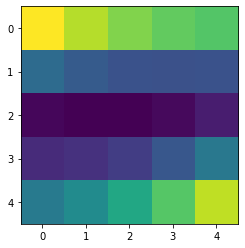

In [19]:
plt.imshow(diff)

Based on these results, we can find the optimal plasmon parameters:

In [20]:
j = diff.argmin() % diff.shape[1]
i = diff[:, j].argmin()
print("Optimal bulk parameter = " + str(bulk_range[i]))
print("Optimal surface parameter = " + str(surface_range[j]))

Optimal bulk parameter = 0.11000000000000001
Optimal surface parameter = 1.6


These parameters have now been set as the defaults in the `QuotasCalculator`.

## Other metals

In [16]:
def display_see(element, surface, ion, smearing=0.001,
                bulk_parameter=None, surface_parameter=None):
    try:
        quotas = QuotasCalculator.from_file(
                os.path.join(data_dir, element + "_" + surface + "_pbe.json")
            )
        quotas.set_up_plasmon_probabilities(bulk_parameter, surface_parameter)
        see = quotas.calculate_yield(ionization_energies[ion])
        energy = see["energy"]
        yield_spectrum = get_smeared_densities(energy, see["yield"], smearing)
        total_yield = see["total_yield"]
        
        workfunction_data = quotas.workfunction_data
        
        print("Surface work function = " 
              + str(round(workfunction_data.work_function, 3)))
        print("Total Yield = " + str(round(total_yield, 3)))
        print()
         
        # Plot the yield spectrum
        plt.rcParams["font.size"] = 16
        plt.plot(energy, yield_spectrum)
        plt.xlabel("Energy (eV)")
        plt.ylabel("$\gamma$ (#electrons/ion)")
        plt.xlim([0, 20])
        
    except FileNotFoundError:
        print("Requested element/surface combination is not available")


In [17]:
interact(display_see,
         element=structure_dict.keys(), 
         surface=["100", "110", "001", "111"], 
         ion=ionization_energies.keys(), 
         smearing=FloatText(0.2, step=0.02),
         bulk_parameter=FloatSlider(0.095, min=0, max=0.2, step=0.005, readout_format=".3f"), 
         surface_parameter=FloatSlider(1.6, min=0, max=2, step=0.01));

interactive(children=(Dropdown(description='element', options=('Ag', 'Al', 'As', 'Au', 'Ba', 'Be', 'Bi', 'Ca',…

### Appendix A: Calculation of the total differences

In [17]:
bulk_range = np.arange(0.10, 0.125, 0.005)
surface_range = np.arange(1.50, 1.75, 0.05)
diff = np.zeros([len(bulk_range), len(surface_range)])

plasmon_element_dict = {
    "Al": ["100", "110", "111"],
    "Mg": ["100", "110", "001"],
    # "Be": ["110"],
    "Ni": ["111"],
    # "W": ["111"],
    "Cu": ["100"]
}

plasmon_ion_list = ["He", "Ne"]

for i, bulk in enumerate(bulk_range):
    for j, surf in enumerate(surface_range):
        print("Evaluating " + str(i) + ";" + str(j))
        diff[i][j] = evaluate_plasmon_parameters(
            bulk, surf, plasmon_element_dict, plasmon_ion_list
        )
        
diff_dict = {
    "bulk_range": bulk_range,
    "surface_range": surface_range,
    "diff": diff
}

with open("diff_data.json", "w") as file:
    file.write(json.dumps(diff_dict, cls=MontyEncoder))

Evaluating 0;0
Evaluating 0;1
Evaluating 0;2
Evaluating 0;3
Evaluating 0;4
Evaluating 1;0
Evaluating 1;1
Evaluating 1;2
Evaluating 1;3
Evaluating 1;4
Evaluating 2;0
Evaluating 2;1
Evaluating 2;2
Evaluating 2;3
Evaluating 2;4
Evaluating 3;0
Evaluating 3;1
Evaluating 3;2
Evaluating 3;3
Evaluating 3;4
Evaluating 4;0
Evaluating 4;1
Evaluating 4;2
Evaluating 4;3
Evaluating 4;4
